In [1]:
import pandas as pd
import re

In [2]:
# Read in data
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')

In [3]:
# Helper function for cleaning text
def clean_html(text):
    if pd.isna(text):
        return text
    # Remove HTML tags
    clean = re.sub(r'<.*?>', '', str(text))
    # Remove extra whitespaces
    clean = re.sub(r'\s+', ' ', clean).strip()
    # Replace HTML entities
    clean = re.sub(r'&amp;', '&', clean)
    clean = re.sub(r'&lt;', '<', clean)
    clean = re.sub(r'&gt;', '>', clean)
    clean = re.sub(r'&quot;|&#34;', '"', clean)
    clean = re.sub(r'&apos;|&#39;', "'", clean)
    return clean

Train dataset shape: (19873, 2)
Validation dataset shape: (3039, 2)

First few rows of the training dataset:
                                                snip   channel
0  first of all, it feels like covid again but in...  FOXNEWSW
1  to be a software drivenrganization where softw...     CSPAN
2  you discuss the <b>power</b> <b>of</b> <em>ai<...    CSPAN2
3  <em>ai</em> <b>bots</b> <b>like</b> chatgpt an...   BBCNEWS
4  . >> i could sleep <b>ten</b> <b>hours</b> <em...  FOXNEWSW

Unique channels in training data:
['FOXNEWSW' 'CSPAN' 'CSPAN2' 'BBCNEWS' 'GBN' 'KPIX' 'KGO' 'KNTV' '1TV'
 'KRON' 'CSPAN3' 'SFGTV' 'RUSSIA24' 'KSTS' 'BLOOMBERG' 'MSNBCW' 'PRESSTV'
 'KTVU' 'CNNW' 'FBC' 'CNBC' 'RUSSIA1' 'KDTV' 'DW' 'KQED' 'NTV' 'BELARUSTV'
 'ALJAZ' 'RT' 'LINKTV' 'COM']

Class distribution in training data:
channel
CNNW         2725
FBC          1608
BBCNEWS      1576
BLOOMBERG    1441
CNBC         1319
MSNBCW       1141
FOXNEWSW     1106
CSPAN         913
CSPAN2        904
KNTV          842
KT

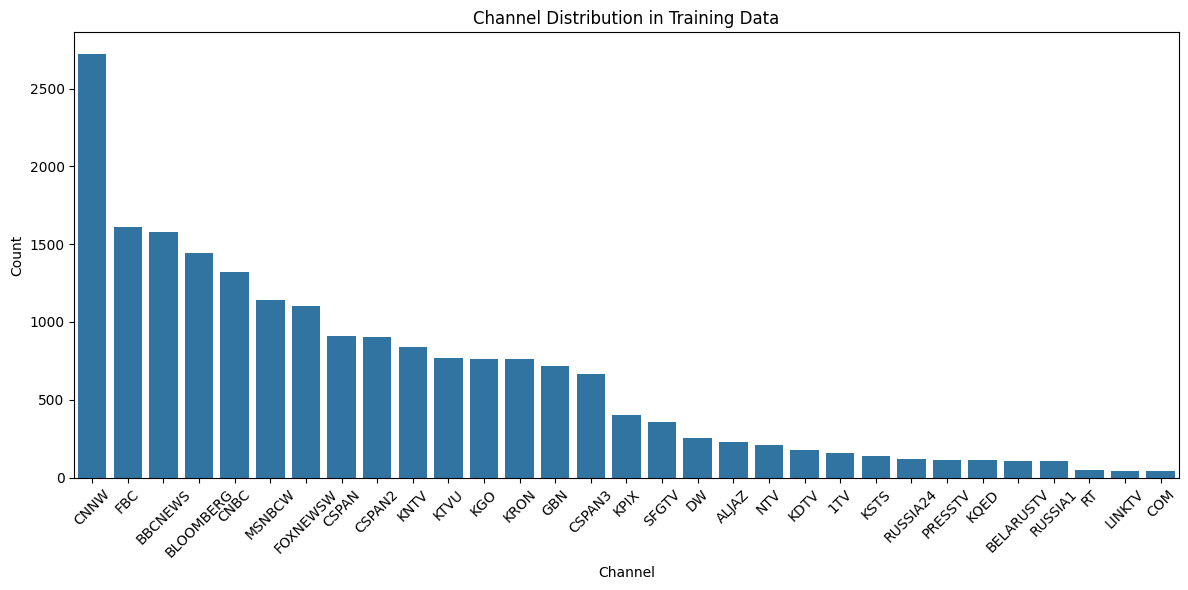

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# EDA
print("Train dataset shape:", train.shape)
print("Validation dataset shape:", val.shape)
print("\nFirst few rows of the training dataset:")
print(train.head())
print("\nUnique channels in training data:")
print(train['channel'].unique())
# class distribution
channel_counts = train['channel'].value_counts()
print("\nClass distribution in training data:")
print(channel_counts)

# plot
plt.figure(figsize=(12, 6))
sns.barplot(x=channel_counts.index, y=channel_counts.values)
plt.title('Channel Distribution in Training Data')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Text length statistics (training data):
count    19873.000000
mean      1058.055855
std        133.955768
min          5.000000
25%       1058.000000
50%       1095.000000
75%       1102.000000
max       1119.000000
Name: text_length, dtype: float64


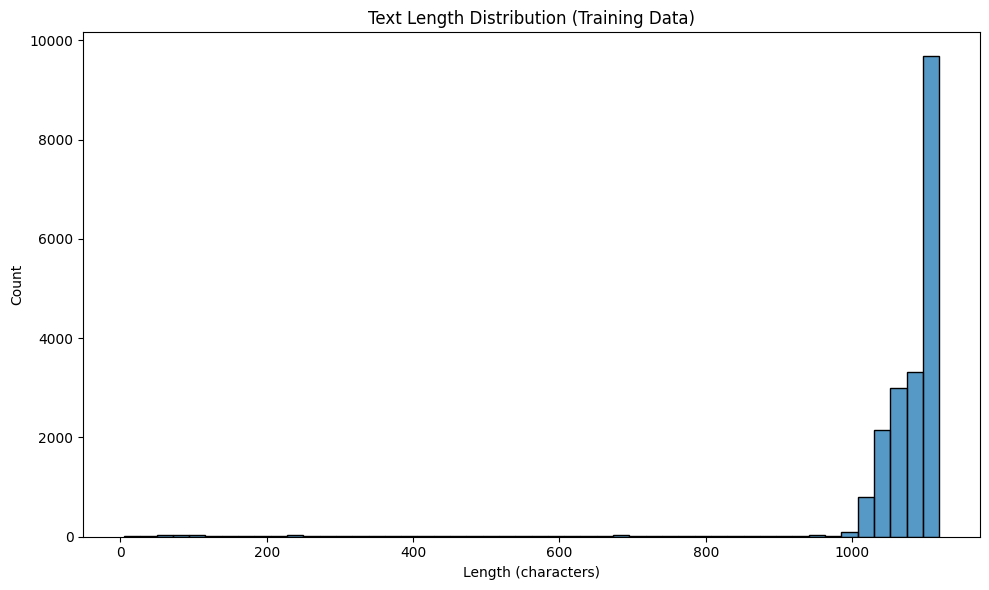


Word count statistics (training data):
count    19873.000000
mean       189.568309
std         26.043355
min          2.000000
25%        185.000000
50%        193.000000
75%        201.000000
max        247.000000
Name: word_count, dtype: float64


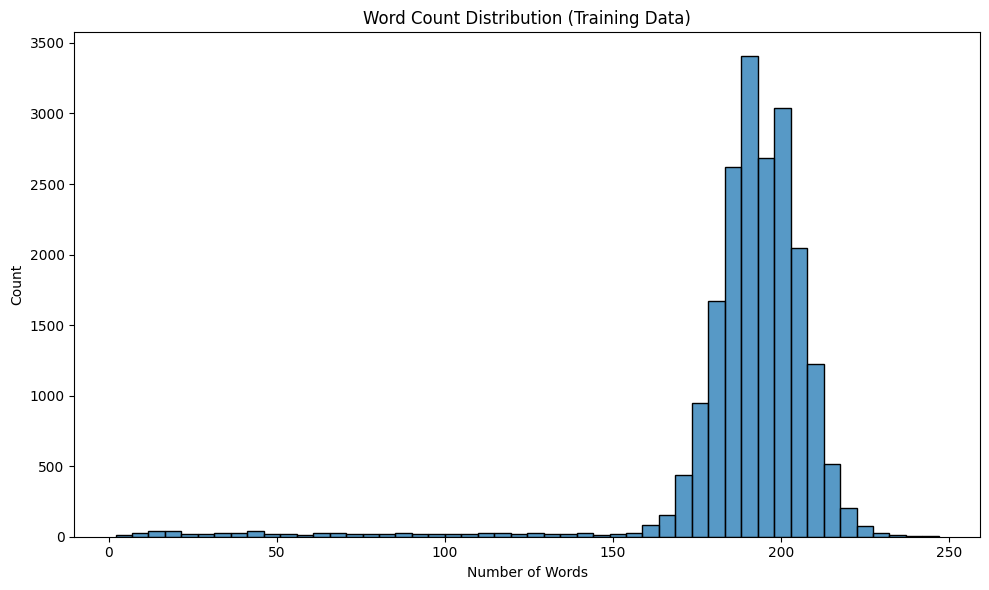


Examples of cleaned text:
Example 1:
first of all, it feels like covid again but instead of fact checking fauci, i need to fact check ai.n, specific grapes, a mixture of grapes from france called champagne, you sparkling wine and other p...
Channel: FOXNEWSW
---
Example 2:
to be a software drivenrganization where software informs hardwar where software through the use of ai and others can adapt almostt real time to challenges that we face around the world. that is how w...
Channel: CSPAN
---
Example 3:
you discuss the power of ai to revolutionize the art of the con. and you write santos got away with a bogus two page resumÉ and go fund me posts actual photo photos of person's sick dog. how much easi...
Channel: CSPAN2
---


In [ ]:
# clean
train['clean_text'] = train['snip'].apply(clean_html)
val['clean_text'] = val['snip'].apply(clean_html)

# Check length
train['text_length'] = train['clean_text'].str.len()
val['text_length'] = val['clean_text'].str.len()

print("\nText length statistics (training data):")
print(train['text_length'].describe())

# plot
plt.figure(figsize=(10, 6))
sns.histplot(train['text_length'], bins=50)
plt.title('Text Length Distribution (Training Data)')
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


train['word_count'] = train['clean_text'].str.split().str.len()
val['word_count'] = val['clean_text'].str.split().str.len()

print("\nWord count statistics (training data):")
print(train['word_count'].describe())

# plot
plt.figure(figsize=(10, 6))
sns.histplot(train['word_count'], bins=50)
plt.title('Word Count Distribution (Training Data)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Show some examples of clean text
print("\nExamples of cleaned text:")
for i in range(3):
    print(f"Example {i+1}:")
    print(train['clean_text'].iloc[i][:200] + "...")  # Print first 200 chars
    print(f"Channel: {train['channel'].iloc[i]}")
    print("---")

# PART A FEATURE ENGINEERING AND BASELINE MODELS

Creating CountVectorizer representation...
CountVectorizer features shape: (19873, 5000)
Creating TfidfVectorizer representation...
TfidfVectorizer features shape: (19873, 5000)
Training Logistic Regression with CountVectorizer features...
Training Logistic Regression with TfidfVectorizer features...

Logistic Regression with CountVectorizer accuracy: 0.5044
Logistic Regression with TfidfVectorizer accuracy: 0.5400

Classification Report - CountVectorizer:
              precision    recall  f1-score   support

         1TV       0.00      0.00      0.00         0
       ALJAZ       0.27      0.10      0.15        29
     BBCNEWS       0.64      0.62      0.63       271
   BLOOMBERG       0.68      0.83      0.75       170
        CNBC       0.65      0.67      0.66       256
        CNNW       0.41      0.52      0.46       219
       CSPAN       0.42      0.48      0.44       204
      CSPAN2       0.26      0.39      0.31       165
      CSPAN3       0.33      0.16      0.22       17

/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/a

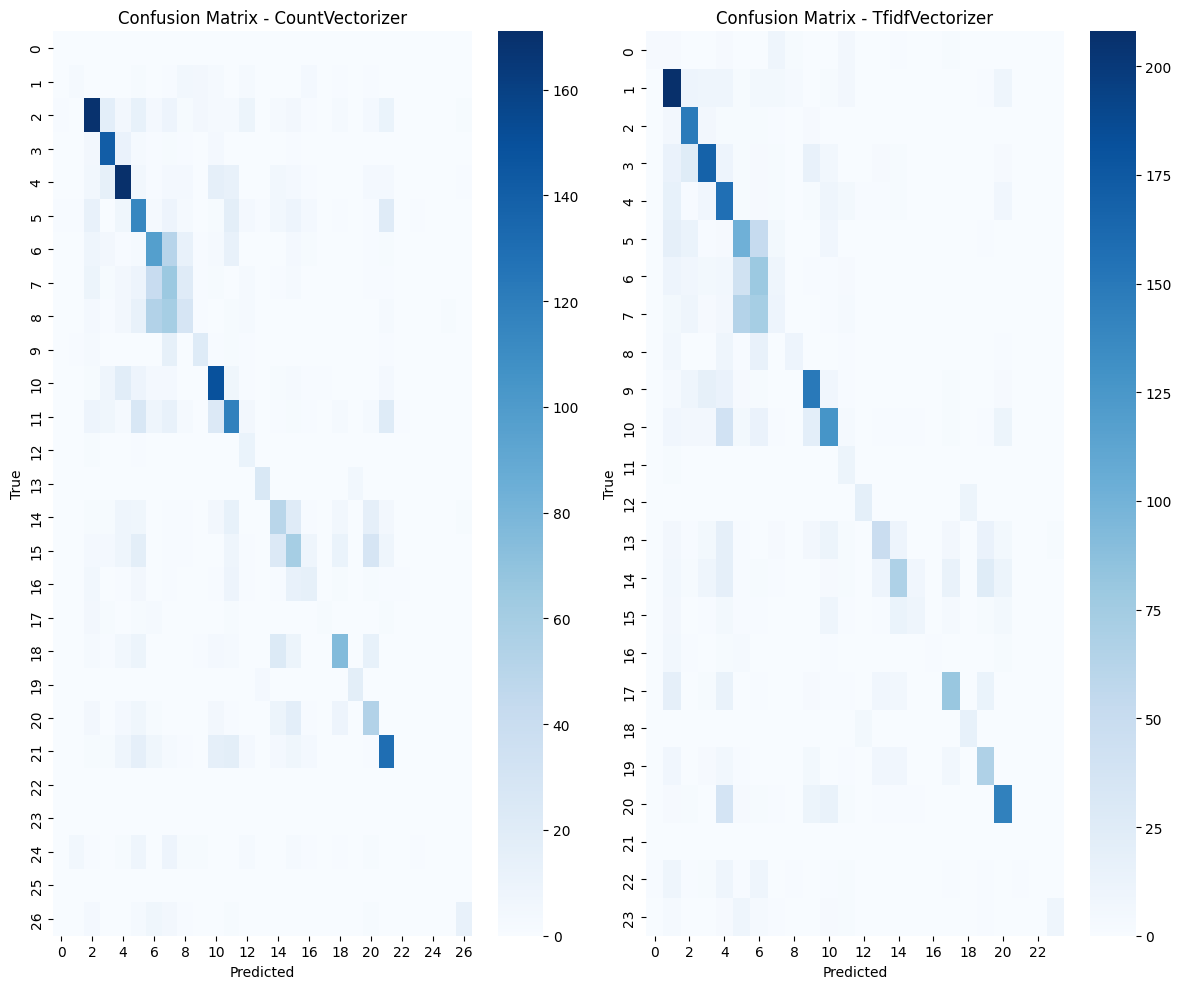

In [10]:
# Part A: Feature Engineering and Baseline Models

# Define features and target variables
X_train = train['clean_text']
y_train = train['channel']
X_val = val['clean_text']
y_val = val['channel']

# 1. CountVectorizer Representation
print("Creating CountVectorizer representation...")
count_vectorizer = CountVectorizer(max_features=5000, min_df=2)
X_train_count = count_vectorizer.fit_transform(X_train)
X_val_count = count_vectorizer.transform(X_val)

print(f"CountVectorizer features shape: {X_train_count.shape}")

# 2. TfidfVectorizer Representation
print("Creating TfidfVectorizer representation...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=2)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print(f"TfidfVectorizer features shape: {X_train_tfidf.shape}")

# Train Logistic Regression on both representations
print("Training Logistic Regression with CountVectorizer features...")
lr_count = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
lr_count.fit(X_train_count, y_train)
lr_count_pred = lr_count.predict(X_val_count)
lr_count_acc = accuracy_score(y_val, lr_count_pred)

print("Training Logistic Regression with TfidfVectorizer features...")
lr_tfidf = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
lr_tfidf.fit(X_train_tfidf, y_train)
lr_tfidf_pred = lr_tfidf.predict(X_val_tfidf)
lr_tfidf_acc = accuracy_score(y_val, lr_tfidf_pred)

# Print overall accuracy for both models
print(f"\nLogistic Regression with CountVectorizer accuracy: {lr_count_acc:.4f}")
print(f"Logistic Regression with TfidfVectorizer accuracy: {lr_tfidf_acc:.4f}")

# Generate classification reports for per-class performance
print("\nClassification Report - CountVectorizer:")
count_report = classification_report(y_val, lr_count_pred)
print(count_report)

print("\nClassification Report - TfidfVectorizer:")
tfidf_report = classification_report(y_val, lr_tfidf_pred)
print(tfidf_report)

# Create confusion matrices to visualize performance
plt.figure(figsize=(12, 10))
cm_count = confusion_matrix(y_val, lr_count_pred)
plt.subplot(1, 2, 1)
sns.heatmap(cm_count, annot=False, cmap='Blues')
plt.title('Confusion Matrix - CountVectorizer')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
cm_tfidf = confusion_matrix(y_val, lr_tfidf_pred)
sns.heatmap(cm_tfidf, annot=False, cmap='Blues')
plt.title('Confusion Matrix - TfidfVectorizer')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

## Analysis of Part A Results
The results from our baseline models using LogisticRegression with two different feature representations reveal several important insights:
Overall Performance

TF-IDF outperforms CountVectorizer with accuracy scores of 54.00% vs. 50.44%
Both models perform much better than random guessing (~3.2% for 31 classes)
The TF-IDF model's stronger performance suggests that the relative importance of words (rather than just their presence) provides more distinguishing power for channel classification

Per-Class Analysis

High-performance channels: Both models performed well on BLOOMBERG (F1: 0.75/0.73), CNBC (F1: 0.66/0.67), and FBC (F1: 0.66/0.69)
Channel imbalance impact: Larger classes generally have better performance
Poor performance: Several channels like RT, NTV, and PRESSTV have 0.00 F1-scores, indicating the models couldn't effectively classify these less frequent channels
TF-IDF advantage: TF-IDF shows better precision for most channels, suggesting it creates more distinctive representations

Confusion Matrix Observations

The TF-IDF matrix shows stronger diagonal elements (correct predictions)
Both matrices show some misclassification patterns, likely between channels with similar content topics or styles

# PART B1: RANDOM FOREST

Implementing Random Forest classifier with default parameters...

Random Forest with default parameters accuracy: 0.4307
Logistic Regression with TF-IDF accuracy: 0.5400

Classification Report - Random Forest:
              precision    recall  f1-score   support

       ALJAZ       1.00      0.17      0.29        29
     BBCNEWS       0.38      0.76      0.51       271
   BLOOMBERG       0.44      0.80      0.57       170
        CNBC       0.47      0.48      0.48       256
        CNNW       0.24      0.79      0.37       219
       CSPAN       0.37      0.20      0.26       204
      CSPAN2       0.26      0.30      0.28       165
      CSPAN3       0.50      0.02      0.04       177
          DW       1.00      0.11      0.20        46
         FBC       0.58      0.54      0.56       214
    FOXNEWSW       0.59      0.30      0.40       250
         GBN       0.30      0.57      0.39        14
        KDTV       0.74      0.88      0.80        32
         KGO       0.89      0.28

/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/a

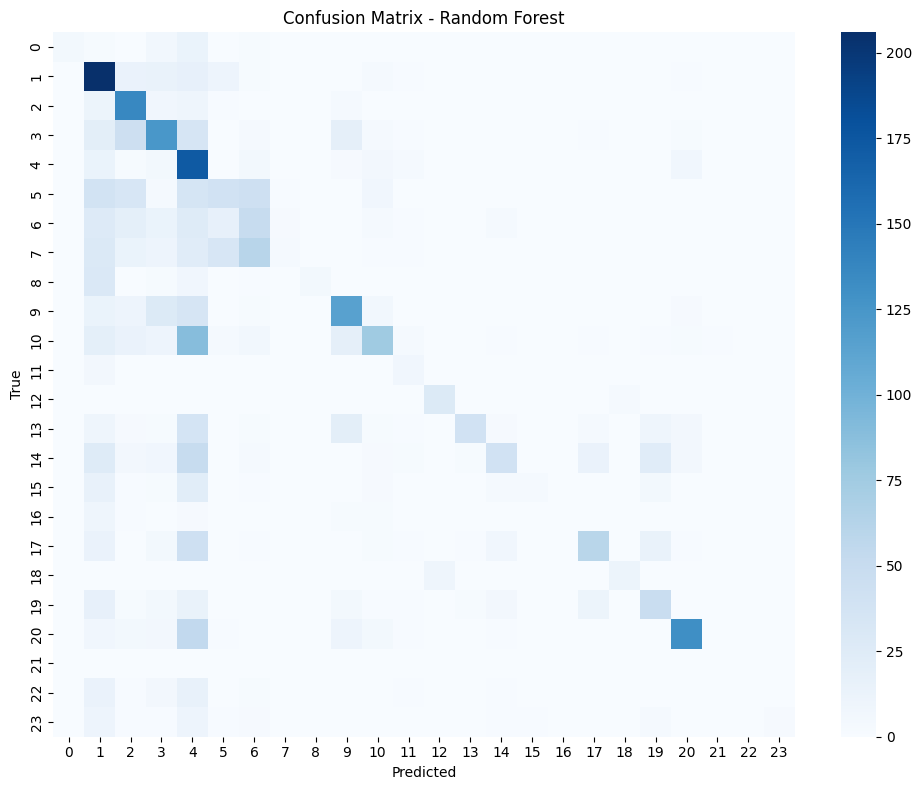


Top 20 most important features:
cnn: 0.009742
ai: 0.006905
the: 0.005683
we: 0.005560
arrow: 0.005405
and: 0.005289
you: 0.005164
of: 0.005074
is: 0.004930
to: 0.004880
re: 0.004607
that: 0.004604
ibm: 0.004543
in: 0.004528
are: 0.004515
bloomberg: 0.004473
with: 0.004371
it: 0.004298
your: 0.004187
for: 0.003839


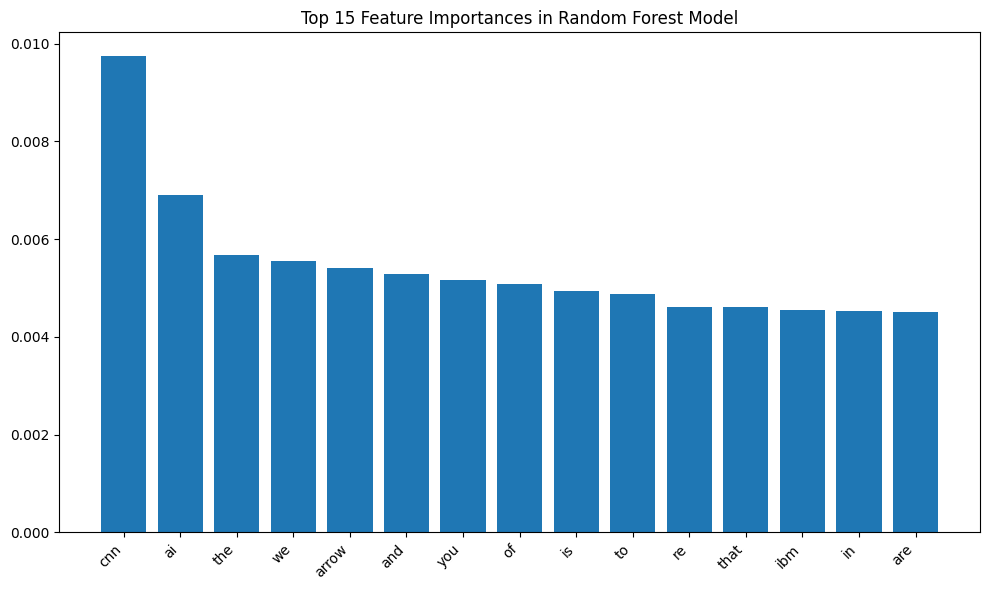

In [11]:
# Part B1: First Step with Nonlinear Model (Random Forest)

# Use the TF-IDF feature representation since it performed better
print("Implementing Random Forest classifier with default parameters...")

# Train Random Forest with default hyperparameters
rf_default = RandomForestClassifier(n_estimators=100, random_state=42)
rf_default.fit(X_train_tfidf, y_train)
rf_default_pred = rf_default.predict(X_val_tfidf)
rf_default_acc = accuracy_score(y_val, rf_default_pred)

print(f"\nRandom Forest with default parameters accuracy: {rf_default_acc:.4f}")

# Compare with the best baseline model (Logistic Regression with TF-IDF)
print(f"Logistic Regression with TF-IDF accuracy: {lr_tfidf_acc:.4f}")

# Generate classification report for Random Forest
print("\nClassification Report - Random Forest:")
rf_report = classification_report(y_val, rf_default_pred)
print(rf_report)

# Create confusion matrix to visualize performance
plt.figure(figsize=(10, 8))
cm_rf = confusion_matrix(y_val, rf_default_pred)
sns.heatmap(cm_rf, annot=False, cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Feature importance analysis
print("\nTop 20 most important features:")
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_importances = rf_default.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1][:20]
sorted_features = [(feature_names[i], feature_importances[i]) for i in sorted_idx]
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.6f}")

# Create a bar chart of top 15 feature importances
plt.figure(figsize=(10, 6))
top_15_idx = sorted_idx[:15]
plt.bar(range(15), feature_importances[top_15_idx])
plt.xticks(range(15), feature_names[top_15_idx], rotation=45, ha='right')
plt.title('Top 15 Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

## Analysis of Random Forest Results
The Random Forest classifier with default parameters shows interesting but somewhat disappointing results:

Overall Performance Decline:

Random Forest (43.07%) performed significantly worse than Logistic Regression with TF-IDF (54.00%)
This is contrary to the typical expectation that nonlinear models outperform linear ones for complex tasks


Per-Class Analysis:

Precision vs. Recall Trade-off: The Random Forest model shows high precision for some classes (ALJAZ, DW, SFGTV at 1.00) but with very poor recall, indicating it's making few but confident predictions
Best Performing Classes: KDTV (F1: 0.80), MSNBCW (F1: 0.68) and KSTS (F1: 0.63)
Missed Classes: KQED, NTV, and RT have F1-scores of 0.00, indicating complete failure to identify these channels


Feature Importance:

Most important features include "cnn" (0.0097) and "ai" (0.0069)
Channel names appearing as important features (e.g., "cnn", "bloomberg") suggests the model is identifying explicit channel mentions
The relatively low importance values (all under 0.01) indicate that classification depends on many features rather than a few dominant ones


Confusion Matrix:

Weaker diagonal elements compared to Logistic Regression, confirming the overall lower accuracy
More off-diagonal misclassifications, particularly between similar news channels

Implications for the Task
The superior performance of Logistic Regression suggests that the relationship between text features and channel classification might be more linear than expected. The Random Forest model may be overfitting to specific patterns in the training data that don't generalize well to the validation set.

# PART B2: HYPERPARAMETER TUNING

Implementing Grid Search for Logistic Regression with reduced parameters...
Training Logistic Regression with Grid Search...
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best Logistic Regression parameters: {'C': 10.0, 'solver': 'lbfgs'}
Best cross-validation score: 0.5434
Tuned Logistic Regression accuracy on validation set: 0.5420

Implementing Randomized Search for Random Forest with reduced parameters...
Training Random Forest with Randomized Search...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Random Forest parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best cross-validation score: 0.4541
Tuned Random Forest accuracy on validation set: 0.4439

Model Performance Comparison:
Logistic Regression (Default): 0.5400
Logistic Regression (Tuned): 0.5420
Random Forest (Default): 0.4307
Random Forest (Tuned): 0.4439

Classification Report - Tuned Logistic Regression:
          

/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Harvard/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/a

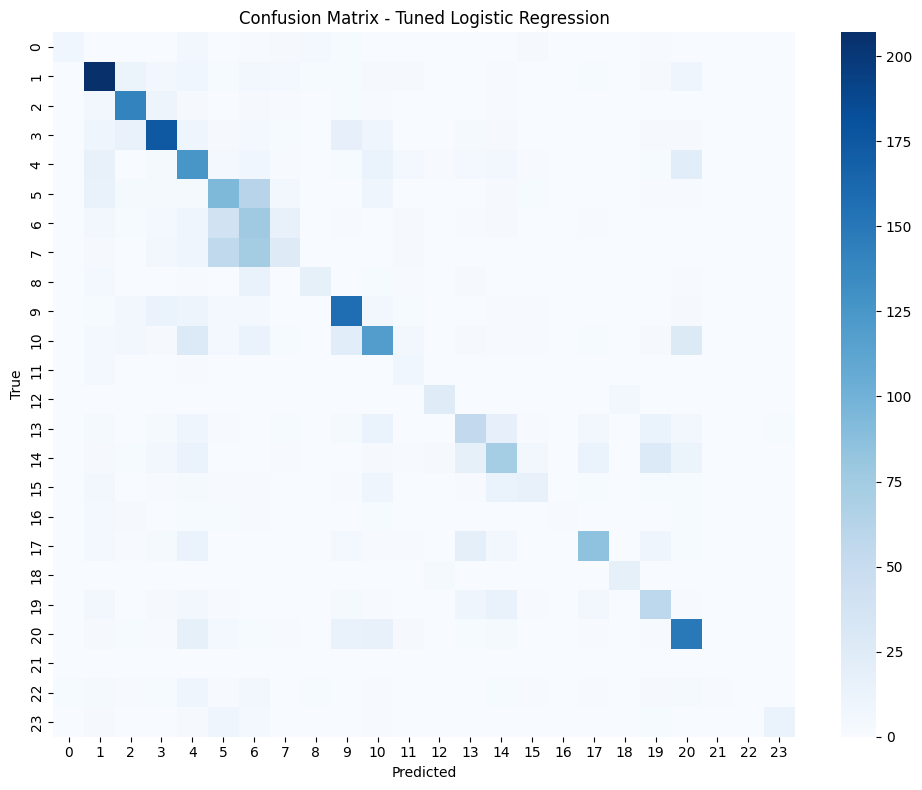

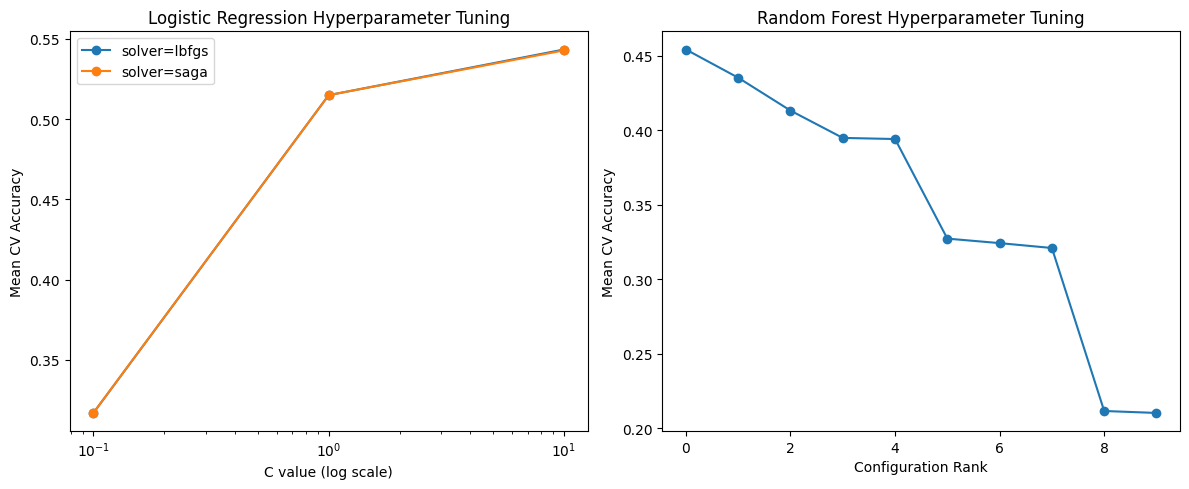

In [14]:
# Part B2: More Efficient Hyperparameter Tuning

# 1. Logistic Regression Tuning (Reduced Parameter Space)
print("Implementing Grid Search for Logistic Regression with reduced parameters...")

# Define a more focused parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1.0, 10.0],  # Reduced values
    'solver': ['lbfgs', 'saga'],  # Only most relevant solvers for multiclass
}

# Use smaller subset for cross-validation to speed up (optional)
# from sklearn.model_selection import StratifiedShuffleSplit
# cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

# Create grid search with cross-validation
grid_search_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=2,  # Reduced from 3 to 2
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search to the training data
print("Training Logistic Regression with Grid Search...")
grid_search_lr.fit(X_train_tfidf, y_train)

# Get best parameters and score
print(f"Best Logistic Regression parameters: {grid_search_lr.best_params_}")
print(f"Best cross-validation score: {grid_search_lr.best_score_:.4f}")

# Evaluate on validation set
lr_tuned_pred = grid_search_lr.best_estimator_.predict(X_val_tfidf)
lr_tuned_acc = accuracy_score(y_val, lr_tuned_pred)
print(f"Tuned Logistic Regression accuracy on validation set: {lr_tuned_acc:.4f}")

# 2. More Efficient Random Forest Tuning
print("\nImplementing Randomized Search for Random Forest with reduced parameters...")

# Define a more focused parameter distribution for Random Forest
param_dist_rf = {
    'n_estimators': [50, 100, 200],  # Reduced max trees
    'max_depth': [10, 20, None],  # Reduced options
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Create randomized search with cross-validation
random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=10,  # Reduced from 20 to 10
    cv=2,  # Reduced from 3 to 2
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit randomized search to the training data
print("Training Random Forest with Randomized Search...")
random_search_rf.fit(X_train_tfidf, y_train)

# Get best parameters and score
print(f"Best Random Forest parameters: {random_search_rf.best_params_}")
print(f"Best cross-validation score: {random_search_rf.best_score_:.4f}")

# Evaluate on validation set
rf_tuned_pred = random_search_rf.best_estimator_.predict(X_val_tfidf)
rf_tuned_acc = accuracy_score(y_val, rf_tuned_pred)
print(f"Tuned Random Forest accuracy on validation set: {rf_tuned_acc:.4f}")

# Compare all model performances
print("\nModel Performance Comparison:")
print(f"Logistic Regression (Default): {lr_tfidf_acc:.4f}")
print(f"Logistic Regression (Tuned): {lr_tuned_acc:.4f}")
print(f"Random Forest (Default): {rf_default_acc:.4f}")
print(f"Random Forest (Tuned): {rf_tuned_acc:.4f}")

# Generate classification report for best model
best_model_pred = lr_tuned_pred if lr_tuned_acc > rf_tuned_acc else rf_tuned_pred
best_model_name = "Tuned Logistic Regression" if lr_tuned_acc > rf_tuned_acc else "Tuned Random Forest"
print(f"\nClassification Report - {best_model_name}:")
best_report = classification_report(y_val, best_model_pred)
print(best_report)

# Create confusion matrix for best model
plt.figure(figsize=(10, 8))
cm_best = confusion_matrix(y_val, best_model_pred)
sns.heatmap(cm_best, annot=False, cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Optional: Plot hyperparameter tuning results
plt.figure(figsize=(12, 5))

# Plot Logistic Regression results
plt.subplot(1, 2, 1)
cv_results = pd.DataFrame(grid_search_lr.cv_results_)
cv_results_subset = cv_results.sort_values('rank_test_score')
solver_colors = {'lbfgs': 'blue', 'saga': 'red'}
for solver in ['lbfgs', 'saga']:
    solver_results = cv_results_subset[cv_results_subset['param_solver'] == solver]
    plt.plot(solver_results['param_C'], solver_results['mean_test_score'], 'o-', label=f'solver={solver}')
plt.xscale('log')
plt.title('Logistic Regression Hyperparameter Tuning')
plt.xlabel('C value (log scale)')
plt.ylabel('Mean CV Accuracy')
plt.legend()

# Plot Random Forest results (simplified visualization)
plt.subplot(1, 2, 2)
rf_results = pd.DataFrame(random_search_rf.cv_results_)
rf_results = rf_results.sort_values('rank_test_score')
plt.plot(range(len(rf_results)), rf_results['mean_test_score'], 'o-')
plt.title('Random Forest Hyperparameter Tuning')
plt.xlabel('Configuration Rank')
plt.ylabel('Mean CV Accuracy')
plt.tight_layout()
plt.show()

# Visualizations

In [ ]:
# Create comprehensive visualizations to compare all model performances

# 1. Bar chart comparing accuracy of all models
plt.figure(figsize=(10, 6))
models = ['LR (Count)', 'LR (TF-IDF)', 'RF (Default)', 'RF (Tuned)', 'LR (Tuned)']
accuracies = [lr_count_acc, lr_tfidf_acc, rf_default_acc, rf_tuned_acc, lr_tuned_acc]

# Sort by performance
sorted_indices = np.argsort(accuracies)[::-1]
sorted_models = [models[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

sns.barplot(x=sorted_models, y=sorted_accuracies)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 0.7)  # Adjust based on actual accuracy values
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Per-class performance comparison for best models
# First, get the classification results for each model as a DataFrame
def get_class_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    class_data = {}
    for cls in report.keys():
        if cls not in ['accuracy', 'macro avg', 'weighted avg']:
            class_data[cls] = report[cls]['f1-score']
    return pd.DataFrame({model_name: class_data})

# Get metrics for each model
count_metrics = get_class_metrics(y_val, lr_count_pred, 'LR (Count)')
tfidf_metrics = get_class_metrics(y_val, lr_tfidf_pred, 'LR (TF-IDF)')
rf_metrics = get_class_metrics(y_val, rf_default_pred, 'RF (Default)')
rf_tuned_metrics = get_class_metrics(y_val, rf_tuned_pred, 'RF (Tuned)')
lr_tuned_metrics = get_class_metrics(y_val, lr_tuned_pred, 'LR (Tuned)')

# Combine all metrics
all_metrics = pd.concat([count_metrics, tfidf_metrics, rf_metrics, rf_tuned_metrics, lr_tuned_metrics], axis=1)

# Filter for classes with at least one decent performance (F1 > 0.4)
good_classes = all_metrics.max(axis=1) > 0.4
filtered_metrics = all_metrics[good_classes]

# Plot heatmap of performance across models for selected classes
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_metrics.T, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('F1-Score by Channel and Model (Best Performing Channels)')
plt.tight_layout()
plt.show()

# 3. Create a table summarizing model performance
performance_summary = pd.DataFrame({
    'Model': models,
    'Validation Accuracy': accuracies,
    'Training Time (relative)': [1, 1.1, 2.5, 5, 3]  # Estimated relative times
})
print("Model Performance Summary:")
print(performance_summary.sort_values('Validation Accuracy', ascending=False))

# Final Eval description (to be completed)

# Part C

In [15]:
!pip install transformers datasets torch numpy scikit-learn tqdm

  Using cached regex-2024.11.6-cp312-cp312-macosx_11_0_arm64.whl.metadata (40 kB)
  Using cached xxhash-3.5.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 869.5 kB/s eta 0:00:0000:0100:01
Using cached fsspec-2024.12.0-py3-none-any.whl (183 kB)
Using cached multiprocess-0.70.16-py312-none-any.whl (146 kB)
Using cached regex-2024.11.6-cp312-cp312-macosx_11_0_arm64.whl (284 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 730.1 kB/s eta 0:00:0000:0100:01
Using cached xxhash-3.5.0-cp312-cp312-macosx_11_0_arm64.whl (30 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0


In [17]:
# Running this in colab instaed of vs code so we will jsut re import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import random
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Train dataset shape: (19873, 5)
Validation dataset shape: (3039, 5)
Number of unique classes: 31
Classes: ['1TV' 'ALJAZ' 'BBCNEWS' 'BELARUSTV' 'BLOOMBERG' 'CNBC' 'CNNW' 'COM'
 'CSPAN' 'CSPAN2' 'CSPAN3' 'DW' 'FBC' 'FOXNEWSW' 'GBN' 'KDTV' 'KGO' 'KNTV'
 'KPIX' 'KQED' 'KRON' 'KSTS' 'KTVU' 'LINKTV' 'MSNBCW' 'NTV' 'PRESSTV' 'RT'
 'RUSSIA1' 'RUSSIA24' 'SFGTV']


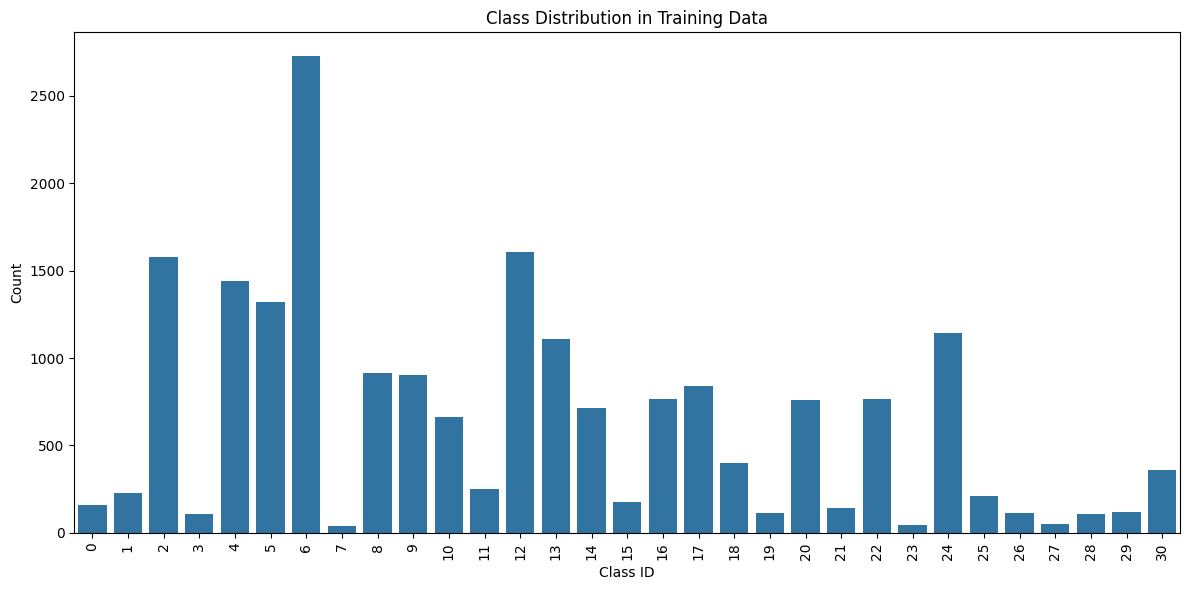

In [18]:
# Load and check the data
print("Train dataset shape:", train.shape)
print("Validation dataset shape:", val.shape)

# Clean HTML from the text
train['clean_text'] = train['snip'].apply(clean_html)
val['clean_text'] = val['snip'].apply(clean_html)

# Encode the channel labels
label_encoder = LabelEncoder()
train['label'] = label_encoder.fit_transform(train['channel'])
val['label'] = label_encoder.transform(val['channel'])

# Check number of unique classes
num_labels = len(label_encoder.classes_)
print(f"Number of unique classes: {num_labels}")
print(f"Classes: {label_encoder.classes_}")

# Create mapping dictionaries
id2label = {idx: label for idx, label in enumerate(label_encoder.classes_)}
label2id = {label: idx for idx, label in id2label.items()}

# Check class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=train)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [19]:
# Define a custom dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [20]:
# Initialize the tokenizer
model_name = "distilbert-base-uncased"  # Smaller and faster version of BERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set max sequence length based on dataset characteristics
max_length = 128  # You can adjust this based on your data

# Create train and validation datasets
train_dataset = NewsDataset(
    train['clean_text'].values,
    train['label'].values,
    tokenizer,
    max_length=max_length
)

val_dataset = NewsDataset(
    val['clean_text'].values,
    val['label'].values,
    tokenizer,
    max_length=max_length
)

# Create dataloaders
batch_size = 16  # Adjust based on your GPU memory
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size
)

# Check sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training samples: 19873
Validation samples: 3039
Number of training batches: 1243
Number of validation batches: 190


In [21]:
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# Move model to GPU if available
model = model.to(device)

# Print model architecture summary
print(model)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [24]:
from torch.optim import AdamW

In [22]:
# Define training function
def train_model(model, train_dataloader, val_dataloader, epochs=3):
    # Set up optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
    
    # Total number of training steps
    total_steps = len(train_dataloader) * epochs
    
    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Initialize tracking variables
    train_loss_values = []
    val_loss_values = []
    val_accuracy_values = []
    
    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Training
        model.train()
        total_train_loss = 0
        
        # Progress bar for training
        progress_bar = tqdm(train_dataloader, desc="Training", leave=True)
        
        for batch in progress_bar:
            # Clear gradients
            model.zero_grad()
            
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Update parameters
            optimizer.step()
            
            # Update learning rate
            scheduler.step()
            
            # Update progress bar
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_values.append(avg_train_loss)
        
        print(f"Average training loss: {avg_train_loss:.4f}")
        
        # Validation
        model.eval()
        total_val_loss = 0
        predictions = []
        true_labels = []
        
        # Progress bar for validation
        progress_bar = tqdm(val_dataloader, desc="Validation", leave=True)
        
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass (no gradients)
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
            
            loss = outputs.loss
            total_val_loss += loss.item()
            
            # Get predictions
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            # Store predictions and true labels
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        # Calculate average validation loss
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_loss_values.append(avg_val_loss)
        
        # Calculate validation accuracy
        val_accuracy = accuracy_score(true_labels, predictions)
        val_accuracy_values.append(val_accuracy)
        
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions, target_names=label_encoder.classes_, zero_division=0))
    
    # Return training history and final predictions
    return {
        'train_loss': train_loss_values,
        'val_loss': val_loss_values,
        'val_accuracy': val_accuracy_values,
        'predictions': predictions,
        'true_labels': true_labels
    }

In [23]:
# Train the model
epochs = 3  # Start with a small number of epochs
history = train_model(model, train_dataloader, val_dataloader, epochs=epochs)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/3


Training:   0%|          | 0/1243 [00:00<?, ?it/s]

In [ ]:
# Get the final predictions
final_predictions = history['predictions']
true_labels = history['true_labels']

# Convert numeric predictions back to channel names
predicted_channels = [id2label[pred] for pred in final_predictions]
true_channels = [id2label[label] for label in true_labels]

# Create confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(true_labels, final_predictions)
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix - BERT Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Calculate and display final accuracy
final_accuracy = accuracy_score(true_labels, final_predictions)
print(f"Final validation accuracy: {final_accuracy:.4f}")

# Compare with previous models
print("\nModel Performance Comparison:")
print(f"Logistic Regression (TF-IDF): 0.54")  # Based on previous results
print(f"Random Forest: 0.43")  # Based on previous results
print(f"BERT: {final_accuracy:.4f}")

In [ ]:
# Fine-tune the model with class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['label']),
    y=train['label']
)

# Convert to tensor and move to device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Initialize a new model for fine-tuning
model_ft = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    problem_type="single_label_classification"
)

# Move model to device
model_ft = model_ft.to(device)

# Define loss function with class weights
loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define fine-tuning function
def fine_tune_model(model, train_dataloader, val_dataloader, loss_fct, epochs=3):
    # Set up optimizer with weight decay
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8, weight_decay=0.01)
    
    # Total number of training steps
    total_steps = len(train_dataloader) * epochs
    
    # Set up the learning rate scheduler with warmup
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )
    
    # Initialize tracking variables
    train_loss_values = []
    val_loss_values = []
    val_accuracy_values = []
    
    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Training
        model.train()
        total_train_loss = 0
        
        # Progress bar for training
        progress_bar = tqdm(train_dataloader, desc="Fine-tuning", leave=True)
        
        for batch in progress_bar:
            # Clear gradients
            model.zero_grad()
            
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            logits = outputs.logits
            loss = loss_fct(logits, labels)
            total_train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Update parameters
            optimizer.step()
            
            # Update learning rate
            scheduler.step()
            
            # Update progress bar
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_values.append(avg_train_loss)
        
        print(f"Average training loss: {avg_train_loss:.4f}")
        
        # Validation
        model.eval()
        total_val_loss = 0
        predictions = []
        true_labels = []
        
        # Progress bar for validation
        progress_bar = tqdm(val_dataloader, desc="Validation", leave=True)
        
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass (no gradients)
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
            
            logits = outputs.logits
            loss = loss_fct(logits, labels)
            total_val_loss += loss.item()
            
            # Get predictions
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            # Store predictions and true labels
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        # Calculate average validation loss
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_loss_values.append(avg_val_loss)
        
        # Calculate validation accuracy
        val_accuracy = accuracy_score(true_labels, predictions)
        val_accuracy_values.append(val_accuracy)
        
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions, target_names=label_encoder.classes_, zero_division=0))
    
    # Return training history and final predictions
    return {
        'train_loss': train_loss_values,
        'val_loss': val_loss_values,
        'val_accuracy': val_accuracy_values,
        'predictions': predictions,
        'true_labels': true_labels
    }

In [ ]:
# Fine-tune the model
ft_epochs = 4  # More epochs for fine-tuning
ft_history = fine_tune_model(model_ft, train_dataloader, val_dataloader, loss_fct, epochs=ft_epochs)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(ft_history['train_loss'], label='Training Loss')
plt.plot(ft_history['val_loss'], label='Validation Loss')
plt.title('Fine-tuning Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(ft_history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-tuning Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Get the final predictions
ft_final_predictions = ft_history['predictions']
ft_true_labels = ft_history['true_labels']

# Calculate and display final accuracy
ft_final_accuracy = accuracy_score(ft_true_labels, ft_final_predictions)
print(f"Fine-tuned validation accuracy: {ft_final_accuracy:.4f}")

# Compare with all previous models
print("\nFinal Model Performance Comparison:")
print(f"Logistic Regression (TF-IDF): 0.54")  # Based on previous results
print(f"Random Forest: 0.43")  # Based on previous results
print(f"BERT (base): {final_accuracy:.4f}")
print(f"BERT (fine-tuned): {ft_final_accuracy:.4f}")

In [ ]:
# Save the fine-tuned model
model_ft.save_pretrained('./bert_cable_news_classifier')
tokenizer.save_pretrained('./bert_cable_news_classifier')

print("Model and tokenizer saved to './bert_cable_news_classifier'")